In [ ]:
import requests
import openpyxl
import schedule
import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import rv_histogram


In [4]:
API_KEY = {'X-API-key': 'PGZ96MHQ'}
s = requests.Session()
s.headers.update(API_KEY)
resp = s.get('http://localhost:9999/v1/case')
resp

<Response [200]>

In [5]:
def get_tick():
    resp = s.get('http://localhost:9999/v1/case')
    if resp.ok:
        return resp.json()['tick']
    return 0

def get_position(ticker):
    resp = s.get('http://localhost:9999/v1/securities')
    if resp.ok:
        for sec in resp.json():
            if sec['ticker'] == ticker:
                return sec['position']
    return 0

def send_order(ticker, action, price, qty):
    params = {
        'ticker': ticker,
        'type': 'LIMIT',
        'quantity': qty,
        'action': action,
        'price': price
    }
    resp = s.post('http://localhost:9999/v1/orders', params=params)
    if resp.ok:
        print(f'✓ {action} {qty} @ {price}')
        return True
    else:
        print(f'✗ FAILED: {resp.text}')
        return False

def cancel_all():
    s.post('http://localhost:9999/v1/commands/cancel', params={'all': 1})
    time.sleep(0.3)

def get_market_info_filtered(ticker):
    """Get best bid/ask EXCLUDING our team (9A, 9B, 9C)"""
    resp = s.get('http://localhost:9999/v1/securities/book', 
                 params={'ticker': ticker})
    if resp.ok:
        book = resp.json()
        
        # Our team members to filter out
        teammates = ['Team 9A', 'Team 9B', 'Team 9C']
        
        # Find best bid NOT from our team
        best_bid = None
        for bid in book['bids']:
            trader = bid.get('trader_id', '')
            if trader not in teammates:
                best_bid = bid['price']
                break
        
        # Find best ask NOT from our team
        best_ask = None
        for ask in book['asks']:
            trader = ask.get('trader_id', '')
            if trader not in teammates:
                best_ask = ask['price']
                break
        
        if best_bid and best_ask:
            mid = (best_bid + best_ask) / 2
        else:
            mid = 500
        
        return best_bid, best_ask, mid
    
    return None, None, 500

def get_my_orders():
    resp = s.get('http://localhost:9999/v1/orders', params={'ticker': 'APPL'})
    if resp.ok:
        return resp.json()
    return []

def get_news():
    resp = s.get('http://localhost:9999/v1/news')
    if resp.ok:
        return resp.json()
    return []

In [6]:
def get_counts():
    file_path = 'data.xlsx'
    counts = pd.DataFrame(s.get('http://localhost:9999/v1//news').json())['headline'].apply(lambda x: int("".join(c for c in x if c.isdigit())))[::-1].tolist()

    wb = openpyxl.load_workbook(filename=file_path)
    sheet = wb.active

    sheet.append(counts)

    wb.save(filename=file_path)

In [154]:
get_counts()

In [ ]:
# Schedule the function to run every 15 minutes
schedule.every(15).minutes.do(get_counts)

# Infinite loop to keep the script running and check the schedule
while True:
    schedule.run_pending()
    time.sleep(1) # Sleep for a short time to avoid high CPU usage

TypeError: the first argument must be callable

(array([6., 5., 7., 7., 4., 9., 3., 7., 5., 3., 7., 9., 1., 5., 8., 6., 5.,
        6., 4., 7., 7., 1., 6., 9., 3.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100.]),
 <BarContainer object of 25 artists>)

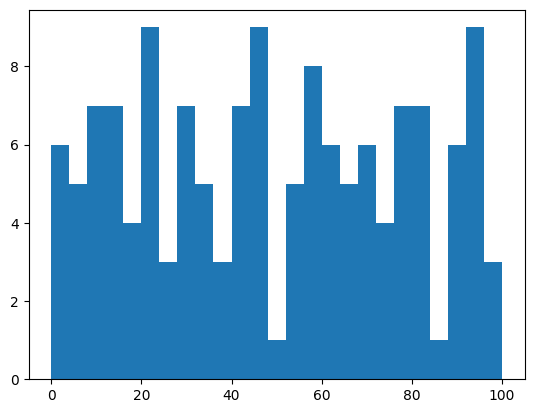

In [48]:
data = pd.read_excel('all_groups_counts.xlsx')
plt.hist(data['Apples'], bins=25)

(array([ 3.,  1.,  1.,  1.,  5.,  3., 11., 12.,  4.,  9.,  8., 12., 15.,
        12., 11.,  8.,  5.,  3.,  3.,  1.,  3.,  2.,  2.,  1.,  2.]),
 array([ 21.  ,  24.16,  27.32,  30.48,  33.64,  36.8 ,  39.96,  43.12,
         46.28,  49.44,  52.6 ,  55.76,  58.92,  62.08,  65.24,  68.4 ,
         71.56,  74.72,  77.88,  81.04,  84.2 ,  87.36,  90.52,  93.68,
         96.84, 100.  ]),
 <BarContainer object of 25 artists>)

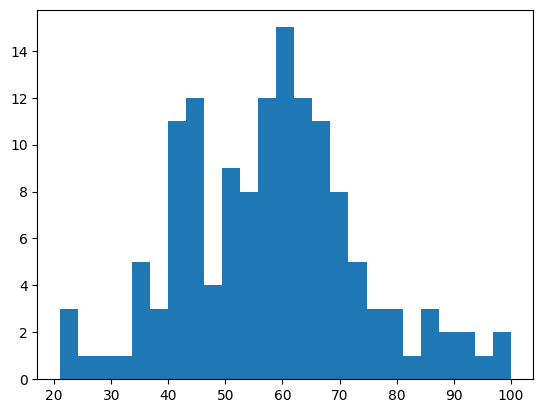

In [49]:
data = pd.read_excel('all_groups_counts.xlsx')
plt.hist(data['Oranges'], bins=25)

In [32]:
import numpy as np
import statistics as st

# Sample data (the same data used for your histogram)
data = pd.read_excel('all_groups_counts.xlsx')

# Calculate statistics
mean_val = np.mean(data) # or st.mean(data)
median_val = np.median(data) # or st.median(data)
std_val = np.std(data) # or st.stdev(data)

print(f"Mean: {mean_val}")
print(f"Median: {median_val}")
print(f"Standard Deviation: {std_val}")

Mean: 71.06217616580311
Median: nan
Standard Deviation: Apples     29.343710
Oranges    16.070309
Fruit      43.064856
dtype: float64


c:\Users\etu89\anaconda3\envs\CitSec_ignite_tradingsim\Lib\site-packages\numpy\_core\fromnumeric.py:4026: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [52]:
data = pd.read_excel('all_groups_counts.xlsx')['Apples'].dropna()
counts, bin_edges = np.histogram(data, bins=30)
hist_dist = rv_histogram((counts, bin_edges))
result_axis0 = np.var(data, axis=0)
print(f"Expected Value: {hist_dist.mean()}")
print(f"Variance: {result_axis0}")

Expected Value: 48.476190476190474
Variance: 841.2230102040816


In [ ]:
def all_data_graph(sym):
    frt = ''
    if sym == 'APPL':
        frt = 'Apples'
    elif sym == 'ORNG':
        frt = 'Oranges'
    elif sym == 'FRUIT':
        frt = 'Fruit'
    data = pd.read_excel('all_groups_counts.xlsx')
    data_count = pd.DataFrame.from_dict(Counter(data[frt]), orient='index', columns=['count']).reset_index()
    plt.bar(data_count['index'], data_count.reset_index()['count'])

ValueError: `bins` must increase monotonically, when an array

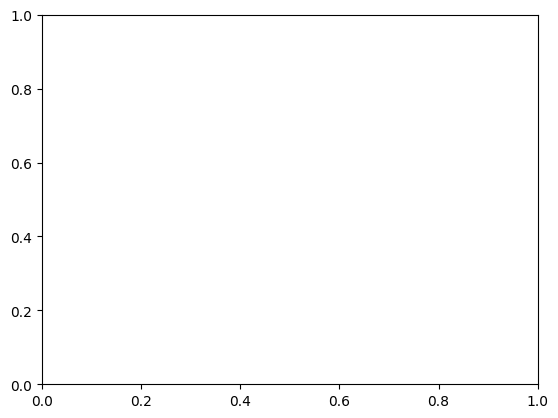

In [19]:
all_data_graph('APPL')

ValueError: `bins` must increase monotonically, when an array

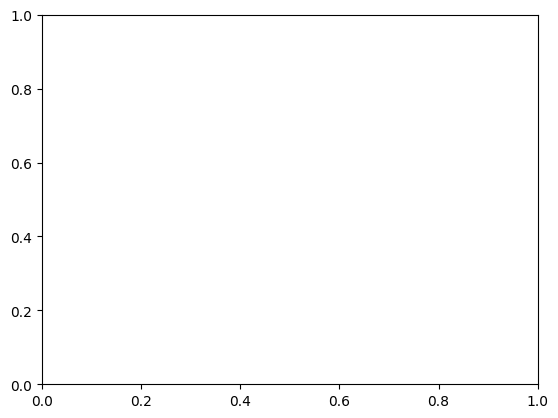

In [20]:
all_data_graph('ORNG')

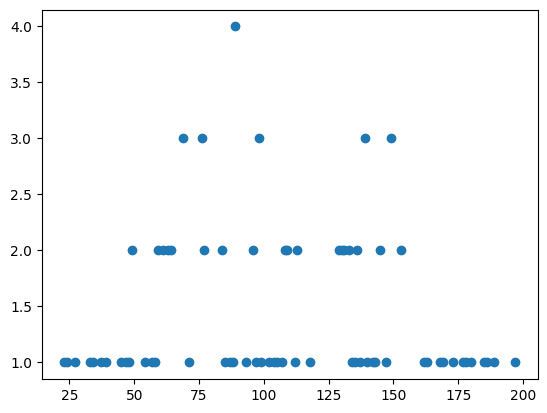

In [152]:
all_data_graph('FRUIT')

In [ ]:
def graph_counts(sym):
    file_path = 'data.xlsx'
    data = pd.read_excel(file_path)
    frt = ''
    frt5 = ''
    frt10 = ''
    if sym == 'APPL':
        frt = 'Apples'
        frt5 = '5 Random Apple'
        frt10 = 'Total Apple'
    elif sym == 'ORNG':
        frt = 'Oranges'
        frt5 = '5 Random Orange'
        frt10 = 'Total Orange'
    frt_df = pd.concat([data[frt], data[frt5]/5, data[frt10]/10]).reset_index(drop=True)
    frt_count = pd.DataFrame.from_dict(Counter(frt_df), orient='index', columns=['count']).reset_index()
    plt.scatter(frt_count['index'], frt_count.reset_index()['count'])

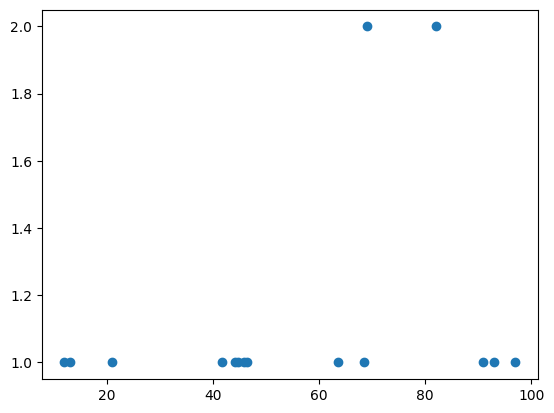

In [124]:
graph_counts('APPL')

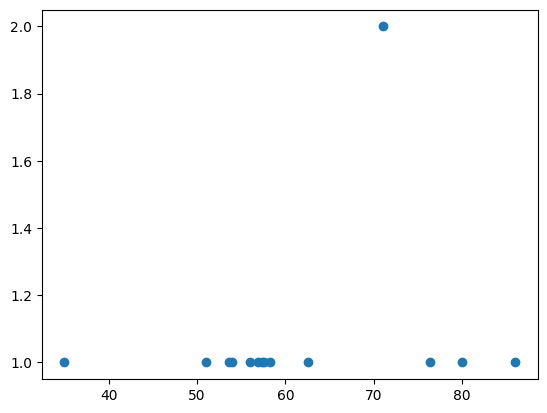

In [125]:
graph_counts('ORNG')

In [10]:
def get_last_filled_price(sym, action):
    
    resp = s.get('http://localhost:9999/v1/orders', params={"ticker": sym, "status": "TRANSACTED", "action": action})
    if resp.ok:
        orders = resp.json()

        if not orders:
            return None
        
        teammates = ['Team 9A', 'Team 9B', 'Team 9C']

        print(orders)
        
        # Most recent filled order
        last_order = max(orders, key=lambda o: o["tick"]) # and not own teammate
        return last_order["price"]
    

In [ ]:
get_last_filled_price('ORNG', 'SELL')

In [62]:
def get_side_volume(sym, levels=5):
    resp = s.get('http://localhost:9999/v1/securities/book', params={"ticker": sym})
    if resp.ok:
        book = resp.json()

        bid_vol = sum(lvl["quantity"] for lvl in book["bids"][:levels])
        ask_vol = sum(lvl["quantity"] for lvl in book["asks"][:levels])

        return bid_vol, ask_vol
    return 0

In [64]:
get_side_volume('ORNG')

(1206.0, 0)

In [75]:

# ============================================
# MAIN STRATEGY
# ============================================

print('='*60)
print('APPL DUAL STRATEGY - LIVE v2')
print('='*60)

harvest_traded = False
new_harvest_traded = False
my_harvest = None
last_tick = 0

while True:
    tick = get_tick()
    
    # # Stop conditions
    # if tick <= 1:
    #     time.sleep(1)
    #     continue
    # if tick > 899:
    #     print('\nCase ending...')
    #     break
    
    pos = get_position('ORNG')
    
    # ==================================================
    # STRATEGY 2: HARVEST BOMB (Tick 360+) - CHECK FIRST
    # ==================================================
    if (tick >= 360 and not harvest_traded) or (tick >= 720 and not new_harvest_traded):
        print('\n' + '='*60)
        print('TICK 360 - HARVEST NEWS!')
        print('='*60)
        
        time.sleep(0.5)
        news = get_news()

        counts = pd.DataFrame(s.get('http://localhost:9999/v1//news').json())['headline'].apply(lambda x: int("".join(c for c in x if c.isdigit())))[::-1].tolist()
        if not harvest_traded and not new_harvest_traded:
            my_harvest = counts[1]
        elif harvest_traded and not new_harvest_traded:
            my_harvest = counts[3]/5            
        
        if my_harvest:
            print(f'\n🍎 YOUR HARVEST: {my_harvest} 🍎\n')
            
            market_mid = get_market_info_filtered('ORNG')[2]
            
            # Risk-managed sizing
            if my_harvest >= 80:
                distance = my_harvest - 80
                confidence = min(distance / 10, 1.0)
                size = int(300 + 200 * confidence)
                price = market_mid + 20
                
                cancel_all()
                send_order('ORNG', 'BUY', price, size)
                print(f'🚀 HIGH HARVEST: Buying {size} @ {price}')
                print(f'   Confidence: {confidence*100:.0f}%\n')
                
            elif my_harvest <= 40:
                distance = 20 - my_harvest
                confidence = min(distance / 10, 1.0)
                size = int(300 + 200 * confidence)
                price = market_mid - 20
                
                cancel_all()
                send_order('ORNG', 'SELL', price, size)
                print(f'🚀 LOW HARVEST: Selling {size} @ {price}')
                print(f'   Confidence: {confidence*100:.0f}%\n')
                
            else:
                if my_harvest > 60:
                    size = 100
                    price = market_mid + 10
                    cancel_all()
                    send_order('ORNG', 'BUY', price, size)
                    print(f'📊 MODERATE: Small buy {size} @ {price}\n')
                else:
                    size = 100
                    price = market_mid - 10
                    cancel_all()
                    send_order('ORNG', 'SELL', price, size)
                    print(f'📊 MODERATE: Small sell {size} @ {price}\n')

            if harvest_traded:
                new_harvest_traded = True
            
            harvest_traded = True
            time.sleep(2)
            print(f'Position after harvest trade: {get_position("ORNG")}\n')
            print('='*60)
    
    # ==================================================
    # STRATEGY 1: SMART BOT SCALPER (Continuous)
    # ==================================================
    if tick != last_tick:
        # FILTER OUT TEAMMATES!
        best_bid, best_ask, mid = get_market_info_filtered('ORNG')
        my_orders = get_my_orders()


        # if vol less than 500, buy/sell at low/high price
        bid_vol, ask_vol = get_side_volume('ORNG')

        if bid_vol <= 500:
            send_order('ORNG', 'BUY', 9.99, 1000)
        if ask_vol <= 500:
            send_order('ORNG', 'SELL', 999.99, 1000)
        

        # Check our current orders
        my_best_bid = None
        my_best_ask = None
        for order in my_orders:
            if order['action'] == 'BUY' and order['status'] == 'OPEN':
                my_best_bid = order['price']+0.01
            if order['action'] == 'SELL' and order['status'] == 'OPEN':
                my_best_ask = order['price']-0.01
        
        # ==================================================
        # POSITION LIMITS AFTER HARVEST
        # ==================================================
        skip_buys = False
        skip_sells = False
        
        if harvest_traded and my_harvest:
            if my_harvest >= 80:  # High harvest - should be LONG
                if pos < -200:  # Too short!
                    print(f'⚠️ Pos {pos} too short for harvest {my_harvest} - ONLY BUYING')
                    skip_sells = True
                elif pos < 0:  # Still short but less extreme
                    skip_sells = True  # Don't sell more
                    
            elif my_harvest <= 40:  # Low harvest - should be SHORT
                if pos > 200:  # Too long!
                    print(f'⚠️ Pos {pos} too long for harvest {my_harvest} - ONLY SELLING')
                    skip_buys = True
                elif pos > 0:  # Still long but less extreme
                    skip_buys = True  # Don't buy more
        
        # ==================================================
        # DIRECTIONAL BIAS AFTER HARVEST
        # ==================================================
        if best_bid and best_ask:
            if harvest_traded and my_harvest:
                if my_harvest >= 80:
                    # High harvest - want to be long, widen offers
                    my_bid = best_bid + 0.01  # Aggressive bids
                    my_ask = best_ask + 50    # Wide offers (don't want to sell)
                    
                elif my_harvest <= 40:
                    # Low harvest - want to be short, widen bids
                    my_bid = best_bid - 50    # Wide bids (don't want to buy)
                    my_ask = best_ask - 0.01  # Aggressive offers
                    
                else:
                    # Moderate - normal market making
                    my_bid = best_bid
                    my_ask = best_ask
            else:
                # Pre-harvest - normal tight market making
                spread = best_ask - best_bid
                if spread > 5:
                    my_bid = best_bid + 0.01
                    my_ask = best_ask - 0.01
                else:
                    my_bid = best_bid
                    my_ask = best_ask
        else:
            # No market from non-teammates - post wide
            my_bid = mid - 20
            my_ask = mid + 20
        
        # ==================================================
        # UPDATE ORDERS (WITH POSITION LIMITS)
        # ==================================================
        need_update = False
        
        if my_best_bid is None or my_best_bid < my_bid:
            need_update = True
        elif my_best_bid:
            my_bid = my_best_bid
        
        if my_best_ask is None or my_best_ask > my_ask:
            need_update = True
        elif my_best_ask:
            my_ask = my_best_ask
        
        if need_update or len(my_orders) == 0:
            cancel_all()
            
            # Only post orders if not blocked by position limits
            if not skip_buys:
                send_order('ORNG', 'BUY', my_bid, 200)
            else:
                print(f'Skipping buy - position limit')
                
            if not skip_sells:
                send_order('ORNG', 'SELL', my_ask, 200)
            else:
                print(f'Skipping sell - position limit')
        
        print(f'Tick {tick} | Pos: {pos} | Bid: {my_bid} | Ask: {my_ask}')
        last_tick = tick
    
    time.sleep(0.5)

# Final cleanup
cancel_all()
final_pos = get_position('ORNG')
print(f'\n{"="*60}')
print(f'FINAL POSITION: {final_pos}')
print('DONE!')
print('='*60)


APPL DUAL STRATEGY - LIVE v2

TICK 360 - HARVEST NEWS!

🍎 YOUR HARVEST: 18 🍎

✓ SELL 340 @ 574.54
🚀 LOW HARVEST: Selling 340 @ 574.54
   Confidence: 20%

Position after harvest trade: -32772.0

✓ SELL 1000 @ 999.99
✓ BUY 200 @ 542.99
✓ SELL 200 @ 595.09
Tick 631 | Pos: -32432.0 | Bid: 542.99 | Ask: 595.09
✓ BUY 1000 @ 9.99
✓ BUY 200 @ 543.04
✓ SELL 200 @ 594.21
Tick 634 | Pos: -32772.0 | Bid: 543.04 | Ask: 594.21
✓ BUY 200 @ 543.05
✓ SELL 200 @ 592.9
Tick 635 | Pos: -32772.0 | Bid: 543.05 | Ask: 592.9
✓ BUY 200 @ 543.06
✓ SELL 200 @ 590.49
Tick 636 | Pos: -32772.0 | Bid: 543.06 | Ask: 590.49
✓ BUY 200 @ 543.0699999999999
✓ SELL 200 @ 583.1800000000001
Tick 637 | Pos: -32690.0 | Bid: 543.0699999999999 | Ask: 583.1800000000001
✓ BUY 1000 @ 9.99
✓ BUY 200 @ 543.08
✓ SELL 200 @ 582.25
Tick 638 | Pos: -32502.0 | Bid: 543.08 | Ask: 582.25
✓ BUY 200 @ 543.09
✓ SELL 200 @ 582.8
Tick 639 | Pos: -32902.0 | Bid: 543.09 | Ask: 582.8
✓ BUY 200 @ 543.1
✓ SELL 200 @ 582.86
Tick 640 | Pos: -33102.0 | 

KeyboardInterrupt: 

In [11]:
tas = s.get('http://localhost:9999/v1/securities/tas', params={'ticker':'ORNG'}).json()

In [18]:
tas_df = pd.DataFrame.from_dict(tas)
tas_df

,id,period,tick,price,quantity
0,4084,1,283,1100.0,37.0
1,4083,1,283,1100.0,155.0
2,4082,1,283,1100.0,76.0
3,4049,1,281,1100.0,37.0
4,4048,1,281,1100.0,106.0
...,...,...,...,...,...
554,50,1,5,1100.0,16.0
555,38,1,4,1100.0,106.0
556,37,1,4,1100.0,159.0
557,12,1,2,1100.0,20.0


In [ ]:
tas_df['price']

0      1100.0
1      1100.0
2      1100.0
3      1100.0
4      1100.0
        ...  
554    1100.0
555    1100.0
556    1100.0
557    1100.0
558    1100.0
Name: price, Length: 559, dtype: float64

In [21]:
Counter(tas_df['price'])

Counter({1100.0: 344, -100.0: 204, 671.64: 4, 667.68: 3, 670.06: 2, 666.43: 2})

In [22]:
history = s.get('http://localhost:9999/v1/securities/history', params={'ticker':'ORNG'}).json()

In [27]:
pd.DataFrame(history)

,tick,open,high,low,close
0,804,1100.0,1100.0,1100.0,1100.0
1,803,1100.0,1100.0,1100.0,1100.0
2,802,1100.0,1100.0,1100.0,1100.0
3,801,1100.0,1100.0,1100.0,1100.0
4,800,1100.0,1100.0,1100.0,1100.0
...,...,...,...,...,...
799,5,1100.0,1100.0,1100.0,1100.0
800,4,1100.0,1100.0,1100.0,1100.0
801,3,1100.0,1100.0,1100.0,1100.0
802,2,0.0,1100.0,0.0,1100.0
